# 항공사고 건수 예측

```
1908년부터 2000년까지 수집한 전 세계 항공 사고 데이터를 사용하여 분석을 진행한다. 
해당 데이터는 전 세계의 민간, 물류 및 군용 비행기 관련 사고 정보를 모두 포함하고 있으며 사고가 발생한 비행기의 종류와 항공 운영국, 사고의 원인에 대한 간략한 설명 등을 포함하고 있다. 데이터에 대한 명세는 아래 표와 같다.

Airplane_Crashes.csv (구분자: tab, 4,761 Rows, 8 Columns)
```

In [1]:
import pandas as pd
import scipy as sp
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('data/Airplane_Crashes.csv', delimiter='\t')
df.head()

Date                            Location                Operator  \
0  09/17/1908                 Fort Myer, Virginia    Military - U.S. Army   
1  07/12/1912             AtlantiCity, New Jersey    Military - U.S. Navy   
2  08/06/1913  Victoria, British Columbia, Canada                 Private   
3  09/09/1913                  Over the North Sea  Military - German Navy   
4  10/17/1913          Near Johannisthal, Germany  Military - German Navy   

                     Type  Aboard  Fatalities  Ground  \
0        Wright Flyer III     2.0         1.0     0.0   
1               Dirigible     5.0         5.0     0.0   
2        Curtiss seaplane     1.0         1.0     0.0   
3  Zeppelin L-1 (airship)    20.0        14.0     0.0   
4  Zeppelin L-2 (airship)    30.0        30.0     0.0   

                                             Summary  
0  During a demonstration flight, a U.S. Army fly...  
1  First U.S. dirigible Akron exploded just offsh...  
2  The first fatal airplane accident in Canada oc...  
3  The airship flew into a thunderstorm and encou...  
4  Hydrogen gas which was being vented was sucked...

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4761 entries, 0 to 4760
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Date        4761 non-null   object 
 1   Location    4743 non-null   object 
 2   Operator    4744 non-null   object 
 3   Type        4735 non-null   object 
 4   Aboard      4739 non-null   float64
 5   Fatalities  4749 non-null   float64
 6   Ground      4740 non-null   float64
 7   Summary     4372 non-null   object 
dtypes: float64(3), object(5)
memory usage: 297.7+ KB


## Q 1

```
(전처리) (Airplane_Crashes.csv를 사용하여) 먼저 항공 사고의 추이가 연(year) 단위로 어떻게 변화하는지 분석하고자 한다. 

주어진 데이터셋에서 각 행은 한 건의 항공 사고 정보를 포함하며, 
각 행이 연간 항공 사고 정보를 포함하는 형태로 데이터셋을 변환하기 위해 다음 지시에 따라 전처리를 수행하시오. 
```

```
Step 1. 세 개 컬럼 ‘Aboard, Fatalities, Ground’에서 결측치(null/na/NaN)를 0으로 대체하시오.
```

In [4]:
# 결측치 확인
df[['Aboard', 'Fatalities', 'Ground']].isnull().sum()

Aboard        22
Fatalities    12
Ground        21
dtype: int64

In [5]:
# 결측치 처리 - 0으로 대체
df[['Aboard', 'Fatalities', 'Ground']] = df[['Aboard', 'Fatalities', 'Ground']].fillna(0) # 코드입력

In [6]:
df[['Aboard', 'Fatalities', 'Ground']].isnull().sum() # 코드입력

Aboard        0
Fatalities    0
Ground        0
dtype: int64

```
Step 2. ‘월/일/년’의 표기형식을 따르는 날짜(Date) 컬럼을 참고하여 연도(변수명: Year) 컬럼을 생성하시오.
```

In [7]:
pd.to_datetime(df['Date']) # 코드입력

0      1908-09-17
1      1912-07-12
2      1913-08-06
3      1913-09-09
4      1913-10-17
          ...    
4756   2000-11-07
4757   2000-11-09
4758   2000-11-15
4759   2000-11-20
4760   2000-11-25
Name: Date, Length: 4761, dtype: datetime64[ns]

In [8]:
pd.to_datetime(df['Date']).dt.year

0       1908
1       1912
2       1913
3       1913
4       1913
        ... 
4756    2000
4757    2000
4758    2000
4759    2000
4760    2000
Name: Date, Length: 4761, dtype: int64

In [10]:
year = pd.to_datetime(df['Date']).dt.year
df.insert(1, 'Year', year)
df.head()

ValueError: cannot insert Year, already exists

In [12]:
df

Date  Year                            Location  \
0     09/17/1908  1908                 Fort Myer, Virginia   
1     07/12/1912  1912             AtlantiCity, New Jersey   
2     08/06/1913  1913  Victoria, British Columbia, Canada   
3     09/09/1913  1913                  Over the North Sea   
4     10/17/1913  1913          Near Johannisthal, Germany   
...          ...   ...                                 ...   
4756  11/07/2000  2000        Luabo, DemocratiRepubliCongo   
4757  11/09/2000  2000                 Fort Wayne, Indiana   
4758  11/15/2000  2000                 Near Luanda, Angola   
4759  11/20/2000  2000                      Miami, Florida   
4760  11/25/2000  2000                      Cordoba, Spain   

                    Operator                          Type  Aboard  \
0       Military - U.S. Army              Wright Flyer III     2.0   
1       Military - U.S. Navy                     Dirigible     5.0   
2                    Private              Curtiss seaplane     1.0   
3     Military - German Navy        Zeppelin L-1 (airship)    20.0   
4     Military - German Navy        Zeppelin L-2 (airship)    30.0   
...                      ...                           ...     ...   
4756           Malu Aviation                   Antonov 32B    11.0   
4757       Superior Aviation  Swearingen SA.226TC Metro II     1.0   
4758              Asa Pesada                 Antonov AN-26    57.0   
4759       American Airlines              Airbus A300-600R   114.0   
4760   Mayoral Executive Jet  Aerospatiale SN-601 Corvette     2.0   

      Fatalities  Ground                                            Summary  
0            1.0     0.0  During a demonstration flight, a U.S. Army fly...  
1            5.0     0.0  First U.S. dirigible Akron exploded just offsh...  
2            1.0     0.0  The first fatal airplane accident in Canada oc...  
3           14.0     0.0  The airship flew into a thunderstorm and encou...  
4           30.0     0.0  Hydrogen gas which was being vented was sucked...  
...          ...     ...                                                ...  
4756         2.0     0.0  Due to a blown tire on takeoff the pilot abort...  
4757         1.0     0.0  During takeoff, the cargo plane struck trees, ...  
4758        57.0     0.0  The plane crashed and exploded in flames into ...  
4759         1.0     0.0  After climbing through 16,000 ft. the crew des...  
4760         1.0     0.0  During the approach, the plane, on a positioni...  

[4761 rows x 9 columns]

```
Step 3. 연도(Year) 별 사고 횟수, 총 탑승자 수, 총 사망자 수를 집계한다. 그 결과 아래 표와 같은 데이터 셋이 생성된다

위의 전처리 과정을 모두 완료한 후, 데이터셋 ‘basetable_1’(89 rows)로 저장한다.
```

![img-0002.png](images/img-0002.png)

In [14]:
# Aboard, Fatalities에 대하여 저장
stats = df.groupby('Year').sum()[['Aboard', 'Fatalities']] # 코드입력
stats

Aboard  Fatalities
Year                    
1908     2.0         1.0
1912     5.0         5.0
1913    51.0        45.0
1915    60.0        40.0
1916   109.0       108.0
...      ...         ...
1996  3058.0      2386.0
1997  2485.0      1673.0
1998  2011.0      1544.0
1999  2758.0       970.0
2000  2357.0      1429.0

[89 rows x 2 columns]

In [17]:
# count를 구한다
count = df.groupby('Year')['Aboard'].count()# 코드입력
count

Year
1908     1
1912     1
1913     3
1915     2
1916     5
        ..
1996    81
1997    68
1998    69
1999    78
2000    76
Name: Aboard, Length: 89, dtype: int64

In [18]:
# basetable_1로 저장한다.
basetable_1 = pd.concat([stats, count], axis=1)
basetable_1.columns=['Yearly_Aboard', 'Yearly_Fatalities', 'Count']
basetable_1 = basetable_1.reset_index()
basetable_1

Year  Yearly_Aboard  Yearly_Fatalities  Count
0   1908            2.0                1.0      1
1   1912            5.0                5.0      1
2   1913           51.0               45.0      3
3   1915           60.0               40.0      2
4   1916          109.0              108.0      5
..   ...            ...                ...    ...
84  1996         3058.0             2386.0     81
85  1997         2485.0             1673.0     68
86  1998         2011.0             1544.0     69
87  1999         2758.0              970.0     78
88  2000         2357.0             1429.0     76

[89 rows x 4 columns]

## Q 1

```
(basetable_1을 사용하여) 먼저 데이터셋에 대해 간단한 EDA를 수행하고자 한다. 

다음 수식에 따라 '연간 항공 사고 사망률' 컬럼(변수명: Yearly_Ratio)을 추가하고, 
'연간 항공 사고 사망률'의 평균과 표준편차를 구한 후, 그 두 값을 더한 값을 기술하시오.

Yearly_Ratio = (Yearly_Fatalities)/(Yearly_Aboard)

-	표준편차는 표본표준편차가 아닌, 모표준편차를 구하시오.
-	평균과 표준편차의 더한 값은 소수점 셋째 자리 이하는 버리고 소수점 둘째 자리까지 기술하시오. 
```

In [19]:
basetable_1['Yearly_Fatalities'] / basetable_1['Yearly_Aboard']

0     0.500000
1     1.000000
2     0.882353
3     0.666667
4     0.990826
        ...   
84    0.780249
85    0.673239
86    0.767777
87    0.351704
88    0.606279
Length: 89, dtype: float64

In [20]:
# 수식에 따라 '연간 항공 사고 사망률' 컬럼(변수명: Yearly_Ratio)을 추가
basetable_1['Yearly_Ratio'] = basetable_1['Yearly_Fatalities'] / basetable_1['Yearly_Aboard'] # 코드입력
basetable_1

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio
0   1908            2.0                1.0      1      0.500000
1   1912            5.0                5.0      1      1.000000
2   1913           51.0               45.0      3      0.882353
3   1915           60.0               40.0      2      0.666667
4   1916          109.0              108.0      5      0.990826
..   ...            ...                ...    ...           ...
84  1996         3058.0             2386.0     81      0.780249
85  1997         2485.0             1673.0     68      0.673239
86  1998         2011.0             1544.0     69      0.767777
87  1999         2758.0              970.0     78      0.351704
88  2000         2357.0             1429.0     76      0.606279

[89 rows x 5 columns]

In [23]:
# 연간 항공 사고 사망률'의 평균과 표준편차를 구한 후, 그 두 값을 더한 값을 기술
# 코드입력
basetable_1['Yearly_Ratio'].mean() + basetable_1['Yearly_Ratio'].std()

0.8981936738351299

**정답: 0.89**

## Q 2

```
항공사고가 발생하지 않아 데이터 상에서 제외된 연도가 있다 

1908~2000년의 데이터 중, 제외된 연도를 추가하여 해당 연도의 사고 횟수(Count)를 0으로 입력한다. 
(Note. 완료 시, 총 데이터 수는 89개에서 93개로 증가) 

이어서 연도(Year) 컬럼을 기준으로 데이터를 오름차순 정렬한다.

위의 전처리 과정을 완료한 후, 데이터셋 ‘basetable_2’로 저장한다.
```

In [24]:
basetable_1

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio
0   1908            2.0                1.0      1      0.500000
1   1912            5.0                5.0      1      1.000000
2   1913           51.0               45.0      3      0.882353
3   1915           60.0               40.0      2      0.666667
4   1916          109.0              108.0      5      0.990826
..   ...            ...                ...    ...           ...
84  1996         3058.0             2386.0     81      0.780249
85  1997         2485.0             1673.0     68      0.673239
86  1998         2011.0             1544.0     69      0.767777
87  1999         2758.0              970.0     78      0.351704
88  2000         2357.0             1429.0     76      0.606279

[89 rows x 5 columns]

In [25]:
year_index = pd.period_range(start='1908', end='2000', freq='Y')
year_index

PeriodIndex(['1908', '1909', '1910', '1911', '1912', '1913', '1914', '1915',
             '1916', '1917', '1918', '1919', '1920', '1921', '1922', '1923',
             '1924', '1925', '1926', '1927', '1928', '1929', '1930', '1931',
             '1932', '1933', '1934', '1935', '1936', '1937', '1938', '1939',
             '1940', '1941', '1942', '1943', '1944', '1945', '1946', '1947',
             '1948', '1949', '1950', '1951', '1952', '1953', '1954', '1955',
             '1956', '1957', '1958', '1959', '1960', '1961', '1962', '1963',
             '1964', '1965', '1966', '1967', '1968', '1969', '1970', '1971',
             '1972', '1973', '1974', '1975', '1976', '1977', '1978', '1979',
             '1980', '1981', '1982', '1983', '1984', '1985', '1986', '1987',
             '1988', '1989', '1990', '1991', '1992', '1993', '1994', '1995',
             '1996', '1997', '1998', '1999', '2000'],
            dtype='period[A-DEC]', freq='A-DEC')

In [26]:
df_year = pd.DataFrame(year_index, columns=['Year'])
df_year

Year
0   1908
1   1909
2   1910
3   1911
4   1912
..   ...
88  1996
89  1997
90  1998
91  1999
92  2000

[93 rows x 1 columns]

In [27]:
df_year['Year'] = df_year['Year'].astype('str')
basetable_1['Year'] = basetable_1['Year'].astype('str')

In [28]:
basetable_2 = pd.merge(df_year, basetable_1, how='left')
basetable_2

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio
0   1908            2.0                1.0    1.0      0.500000
1   1909            NaN                NaN    NaN           NaN
2   1910            NaN                NaN    NaN           NaN
3   1911            NaN                NaN    NaN           NaN
4   1912            5.0                5.0    1.0      1.000000
..   ...            ...                ...    ...           ...
88  1996         3058.0             2386.0   81.0      0.780249
89  1997         2485.0             1673.0   68.0      0.673239
90  1998         2011.0             1544.0   69.0      0.767777
91  1999         2758.0              970.0   78.0      0.351704
92  2000         2357.0             1429.0   76.0      0.606279

[93 rows x 5 columns]

In [29]:
basetable_2 = basetable_2.fillna(0)
basetable_2

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio
0   1908            2.0                1.0    1.0      0.500000
1   1909            0.0                0.0    0.0      0.000000
2   1910            0.0                0.0    0.0      0.000000
3   1911            0.0                0.0    0.0      0.000000
4   1912            5.0                5.0    1.0      1.000000
..   ...            ...                ...    ...           ...
88  1996         3058.0             2386.0   81.0      0.780249
89  1997         2485.0             1673.0   68.0      0.673239
90  1998         2011.0             1544.0   69.0      0.767777
91  1999         2758.0              970.0   78.0      0.351704
92  2000         2357.0             1429.0   76.0      0.606279

[93 rows x 5 columns]

```
(basetable_2를 사용하여) 이번 문제에서는 다양한 평활 기법 (smoothing)을 활용하여 사고 횟수(Count)를 예측하고자 한다.

사고 횟수(Count)에 적용할 평활 기법은 
(1) Simple Moving Average 
(2) Weighted Moving Average
(3) Exponential Moving Average 입니다. 

함수 가이드

DataFrame.ewm() 함수 사용
- adjust=False
문제 지시사항 외 default 파라미터 사용


예측 모델 생성 시 필요한 parameter의 명세는 다음 표를 참고하시오.
```

![img-0003.png](images/img-0003.png)

```
Step 1. Simple Moving Average, Weighted Moving Average는 window size가 k일 때, 
최근 k개(t-k+1, … , t시점)의 데이터로부터 t+1 시점 값을 예측한다. (그림 1 참고)

'평활 기법별 파라미터 가이드'에 따라 시점별 예측값을 생성한다. 
(Note. 예측값은 Simple Moving Average의 경우 88개, Weighted Moving Average의 경우 90개가 생성된다.)
```

![img-0004.png](images/img-0004.png)

In [30]:
# Simple Moving Average의 경우 88개
simple_moving_avg = basetable_2['Count'].rolling(window=5).mean().shift(1).dropna()
simple_moving_avg

5      0.4
6      0.8
7      0.8
8      1.2
9      2.2
      ... 
88    81.4
89    80.0
90    76.4
91    76.8
92    75.0
Name: Count, Length: 88, dtype: float64

In [32]:
# Weighted Moving Average
weights = np.array([0.5, 0.25, 0.25])
def weighted_mean(weight_array):
    def inner(x):
        return (weight_array * x).mean()
    return inner

In [33]:
# Weighted Moving Average의 경우 90개가 생성
weighted_moving_avg = basetable_2['Count'].rolling(3).apply(lambda counts: np.dot(counts, weights) / weights.sum(), raw=True).shift(1).dropna()
weighted_moving_avg

3      0.50
4      0.00
5      0.25
6      1.00
7      1.25
      ...  
88    75.00
89    83.50
90    76.75
91    74.75
92    70.75
Name: Count, Length: 90, dtype: float64

```
Step 2. Exponential Moving Average는 t시점의 실제 값과 예측 값으로 t+1시점 값을 예측한다.
'평활 기법별 파라미터 가이드'에 따라 시점별 예측값을 생성한다. (Note. 예측값은 92개가 생성된다.)
```

In [34]:
# Exponential Moving Average
exponential_moving_avg = basetable_2['Count'].ewm(3, adjust=False).mean().shift(1).dropna()
exponential_moving_avg

1      1.000000
2      0.750000
3      0.562500
4      0.421875
5      0.566406
        ...    
88    79.808606
89    80.106455
90    77.079841
91    75.059881
92    75.794911
Name: Count, Length: 92, dtype: float64

```
Step 3. 각 방법론에 따라 생성된 모델을 평가하기 위해 MAE(Mean Absolute Error)를 평가 지표로 사용한다. MAE는 편차의 절대값에 대한 평균으로, 이 값이 작을수록 좋은 성능의 평활 모델이라고 볼 수 있다. (아래 식 참고, f : 예측값, y: 실제값)

세 가지 방법론에 대한 MAE를 계산하고, 이 값이 가장 작은 방법론의 MAE를 기술하시오.

-	각 방법론 사용 결과 예측값이 없는 값, 즉 window size 만큼의 결측치를 제거한 후 MAE를 계산하시오. 
Simple Moving Average의 경우 88개
Weighted Moving Average의 경우 90개, 
Exponential Moving Average의 경우 92개 
예측값을 활용하여 MAE를 계산한다.

-	MAE는 소수점 넷째 자리 이하는 버리고 소수점 셋째 자리까지 기술하시오.
 (답안 예시) 5.012
```

![mae error](https://datavedas.com/wp-content/uploads/2018/04/image017.png)

In [35]:
basetable_2['simple_moving_avg'] = simple_moving_avg
basetable_2['weighted_moving_avg'] = weighted_moving_avg
basetable_2['exponential_moving_avg'] = exponential_moving_avg

In [36]:
basetable_2.head()

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio  \
0  1908            2.0                1.0    1.0           0.5   
1  1909            0.0                0.0    0.0           0.0   
2  1910            0.0                0.0    0.0           0.0   
3  1911            0.0                0.0    0.0           0.0   
4  1912            5.0                5.0    1.0           1.0   

   simple_moving_avg  weighted_moving_avg  exponential_moving_avg  
0                NaN                  NaN                     NaN  
1                NaN                  NaN                1.000000  
2                NaN                  NaN                0.750000  
3                NaN                  0.5                0.562500  
4                NaN                  0.0                0.421875

In [37]:
basetable_2

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio  \
0   1908            2.0                1.0    1.0      0.500000   
1   1909            0.0                0.0    0.0      0.000000   
2   1910            0.0                0.0    0.0      0.000000   
3   1911            0.0                0.0    0.0      0.000000   
4   1912            5.0                5.0    1.0      1.000000   
..   ...            ...                ...    ...           ...   
88  1996         3058.0             2386.0   81.0      0.780249   
89  1997         2485.0             1673.0   68.0      0.673239   
90  1998         2011.0             1544.0   69.0      0.767777   
91  1999         2758.0              970.0   78.0      0.351704   
92  2000         2357.0             1429.0   76.0      0.606279   

    simple_moving_avg  weighted_moving_avg  exponential_moving_avg  
0                 NaN                  NaN                     NaN  
1                 NaN                  NaN                1.000000  
2                 NaN                  NaN                0.750000  
3                 NaN                 0.50                0.562500  
4                 NaN                 0.00                0.421875  
..                ...                  ...                     ...  
88               81.4                75.00               79.808606  
89               80.0                83.50               80.106455  
90               76.4                76.75               77.079841  
91               76.8                74.75               75.059881  
92               75.0                70.75               75.794911  

[93 rows x 8 columns]

In [38]:
basetable_2.loc[basetable_2['simple_moving_avg'].notnull(), ['Count', 'simple_moving_avg']]

Count  simple_moving_avg
5     3.0                0.4
6     0.0                0.8
7     2.0                0.8
8     5.0                1.2
9     6.0                2.2
..    ...                ...
88   81.0               81.4
89   68.0               80.0
90   69.0               76.4
91   78.0               76.8
92   76.0               75.0

[88 rows x 2 columns]

In [40]:
from sklearn.metrics import mean_absolute_error

def mae(col_name):
    x = basetable_2.loc[basetable_2[col_name].notnull(), ['Count', col_name]]
    return mean_absolute_error(x.iloc[:, 0], x.iloc[:, 1]).round(3)

In [41]:
# simple_moving_avg
mae('simple_moving_avg')

8.582

In [42]:
# weighted_moving_avg
mae('weighted_moving_avg')

8.183

In [43]:
# exponential_moving_avg
mae('exponential_moving_avg')

8.078

## Q 3

```
(basetable_2를 사용하여) 다음으로 ARIMA(Auto-Regressive Integrated Moving Average) 기법을 활용하여 사고 횟수(Count) 예측 모델을 생성한다.

ARIMA는 AR모델과 MA모델 그리고 차분의 개념을 포함하는 모델로서, ARIMA 모델을 학습하기 위해서는 세 가지 주요 파라미터 
'AR 모델의 차수(p)', '차분의 횟수(d)', 'MA 모델의 차수(q)'를 설정해주어야 한다.
 ```

![img-0005.png](images/img-0005.png)

```
ARIMA모델을 학습하기 위해서는 먼저 적절한 p, d, q를 결정한다. 
이를 위해, 연도(Year)를 기준으로 오름차순 정렬된 basetable_2의 첫 65개 데이터를 사용하여 다음의 지시대로 수행하시오.
```

In [44]:
df_arima = basetable_2.iloc[:65]
df_arima

Year  Yearly_Aboard  Yearly_Fatalities  Count  Yearly_Ratio  \
0   1908            2.0                1.0    1.0      0.500000   
1   1909            0.0                0.0    0.0      0.000000   
2   1910            0.0                0.0    0.0      0.000000   
3   1911            0.0                0.0    0.0      0.000000   
4   1912            5.0                5.0    1.0      1.000000   
..   ...            ...                ...    ...           ...   
60  1968         2928.0             2156.0   96.0      0.736339   
61  1969         2383.0             1799.0   82.0      0.754931   
62  1970         2681.0             2049.0   87.0      0.764267   
63  1971         2567.0             1932.0   67.0      0.752630   
64  1972         3635.0             2937.0  104.0      0.807978   

    simple_moving_avg  weighted_moving_avg  exponential_moving_avg  
0                 NaN                  NaN                     NaN  
1                 NaN                  NaN                1.000000  
2                 NaN                  NaN                0.750000  
3                 NaN                 0.50                0.562500  
4                 NaN                 0.00                0.421875  
..                ...                  ...                     ...  
60               71.2                74.50               71.851452  
61               78.8                81.25               77.888589  
62               81.4                90.00               78.916442  
63               85.0                90.25               80.937331  
64               84.6                79.50               77.452998  

[65 rows x 8 columns]

```
- (d의 설정) 차분의 횟수는 반복적인 정상성 검정에 의해 결정된다.  
'Augmented Dickey-Fuller Unit Root Test'를 통해 정상성 조건이 만족(유의 수준(Significance level)을 0.05)될 때까지 차분을 수행하고, 이 때 진행한 최소 차분의 횟수를 d로 설정한다.

from statsmodels.tsa.stattools import adfuller 사용
문제 지시사항 외 default 파라미터 사용

- (p,q의 설정) AR, MA 모델의 차수는 d회 차분된 데이터에 대해 ‘편자기상관 함수(Partial Autocorrelation Function, PACF)’, ‘자기상관 함수(Autocorrelation Function, ACF)’를 활용하여 구한다. 

from statsmodels.graphics.tsaplots import plot_pacf 사용
from statsmodels.graphics.tsaplots import plot_acf 사용
문제 지시사항 외 default 파라미터 사용
```

[from statsmodels.tsa.stattools import adfuller](https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html)

- Null Hypothesis (H0): If failed to be rejected, it suggests the time series has a unit root, meaning it is non-stationary. It has some time dependent structure.
- Alternate Hypothesis (H1): The null hypothesis is rejected; it suggests the time series does not have a unit root, meaning it is stationary. It does not have time-dependent structure.

요약
- non-stationary: time-dependent 하다.
- stationary: time-dependent 하지 않다.

In [45]:
df_arima['Count']

0       1.0
1       0.0
2       0.0
3       0.0
4       1.0
      ...  
60     96.0
61     82.0
62     87.0
63     67.0
64    104.0
Name: Count, Length: 65, dtype: float64

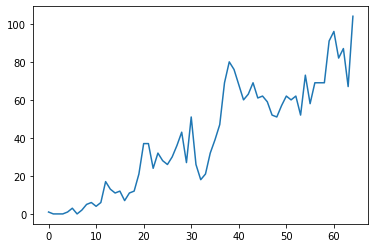

In [46]:
plt.plot(df_arima['Count'])

In [47]:
from statsmodels.tsa.stattools import adfuller

In [48]:
# p-value <= 0.05인경우 H1채택, stationary(no time-dependent) / 차분이 필요 없게 되며, d=0이다
# p-value > 0.05인경우, H0채택, non-stationary(time-dependent) / 차분이 필요하다.
result = adfuller(df_arima['Count'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -0.639686
p-value: 0.861760
Critical Values:
	1%: -3.539
	5%: -2.909
	10%: -2.592


p-value: 1.558768546588128e-17


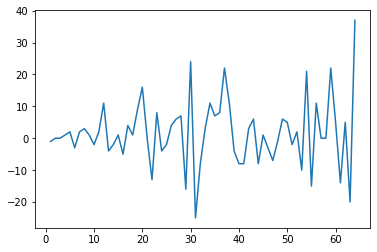

In [49]:
# 1차 차분된 결과 이며 Augmented Dickey-Fuller Test를 적용한 결과
diff_1 = df_arima['Count'].diff().dropna()
plt.plot(diff_1)
print("p-value:", adfuller(diff_1.dropna())[1])

p-value가 0.05보다 작으므로 1차 차분(d=1) 채택

p-value: 1.7020252822472754e-07


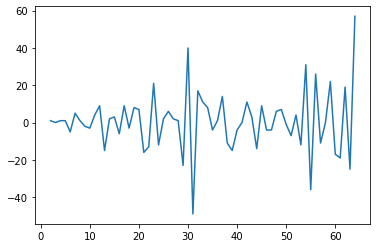

In [50]:
# 2차 차분된 결과 이며 Augmented Dickey-Fuller Test를 적용한 결과
diff_2 = df_arima['Count'].diff().diff().dropna()
plt.plot(diff_2)
print("p-value:", adfuller(diff_2.dropna())[1])

p-value > 0.05이므로 H1를 채택한다.

H0 = time series data is stationary (time-dependent)

즉, 시계열 데이터(Count)가 non-stationary 이며 시간에 dependent 함을 의미한다.

In [51]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(diff_1)
plot_pacf(diff_1)
plt.show()

```
이제 위에서 결정한 p, d, q 를 이용해 ARIMA 모델을 학습하고, 사고 횟수(Count)를 예측하겠습니다. 총 93개의 데이터 중, p, d, q를 결정하는데 사용되지 않은 28개 데이터에 대한 예측을 다음 방법으로 수행하시오
- (예측방법) 사고 횟수(Count) 컬럼의 첫 번째부터 (65+i-1)번째까지의 실제값 데이터로 ARIMA(p, d, q) 모델 생성 후, (65+i)번째 데이터 예측한다.(1≤i≤28) 즉, 이전 시점까지의 실제데이터를 이용하여 해당 시점의 값을 예측하는 작업을 28회 반복한다.

```

In [52]:
from statsmodels.tsa.arima_model import ARIMA 

In [53]:
model = ARIMA(df_arima['Count'], order=(1,1,1))
model_fit = model.fit()

In [54]:
# Actual vs Forecast
model_fit.plot_predict(dynamic=False)
plt.show()

In [55]:
counts = df_arima['Count'].tolist()

# 8개 데이터에 대한 예측을 다음 방법으로 수행하시오
# (예측방법) 사고 횟수(Count) 컬럼의 첫 번째부터 (65+i-1)번째까지의 실제값 데이터로 ARIMA(p, d, q) 모델 생성 후, 
# (65+i)번째 데이터 예측한다.(1≤i≤28) 
# 즉, 이전 시점까지의 실제데이터를 이용하여 해당 시점의 값을 예측하는 작업을 28회 반복
for i in range(28):
    X = counts[-65:]
    model = ARIMA(X, order=(1,0,1))
    model_fit = model.fit()
    fc, se, conf = model_fit.forecast(1) 
    counts.append(fc[0])
    
len(counts)
counts[-5:]

[74.40914065104407,
 73.79004971380299,
 73.20147166811056,
 72.66767978738235,
 72.19423710711887]

In [56]:
plt.plot(basetable_2.iloc[65:]['Count'].values, label='actual')
plt.plot(counts[65:], label='forecast')
plt.legend()
plt.show()

In [57]:
from sklearn.metrics import mean_squared_error

mean_squared_error(basetable_2.iloc[65:]['Count'].values, np.array(counts[65:]))

147.86855607335116

**정답: 147.86**